In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [6]:
# Iris dataset
import seaborn as sns

In [14]:
# Load IRIS dataset from Seaborn
iris = sns.load_dataset('iris')
X, y = iris.iloc[:, :-1], iris.iloc[:, -1]


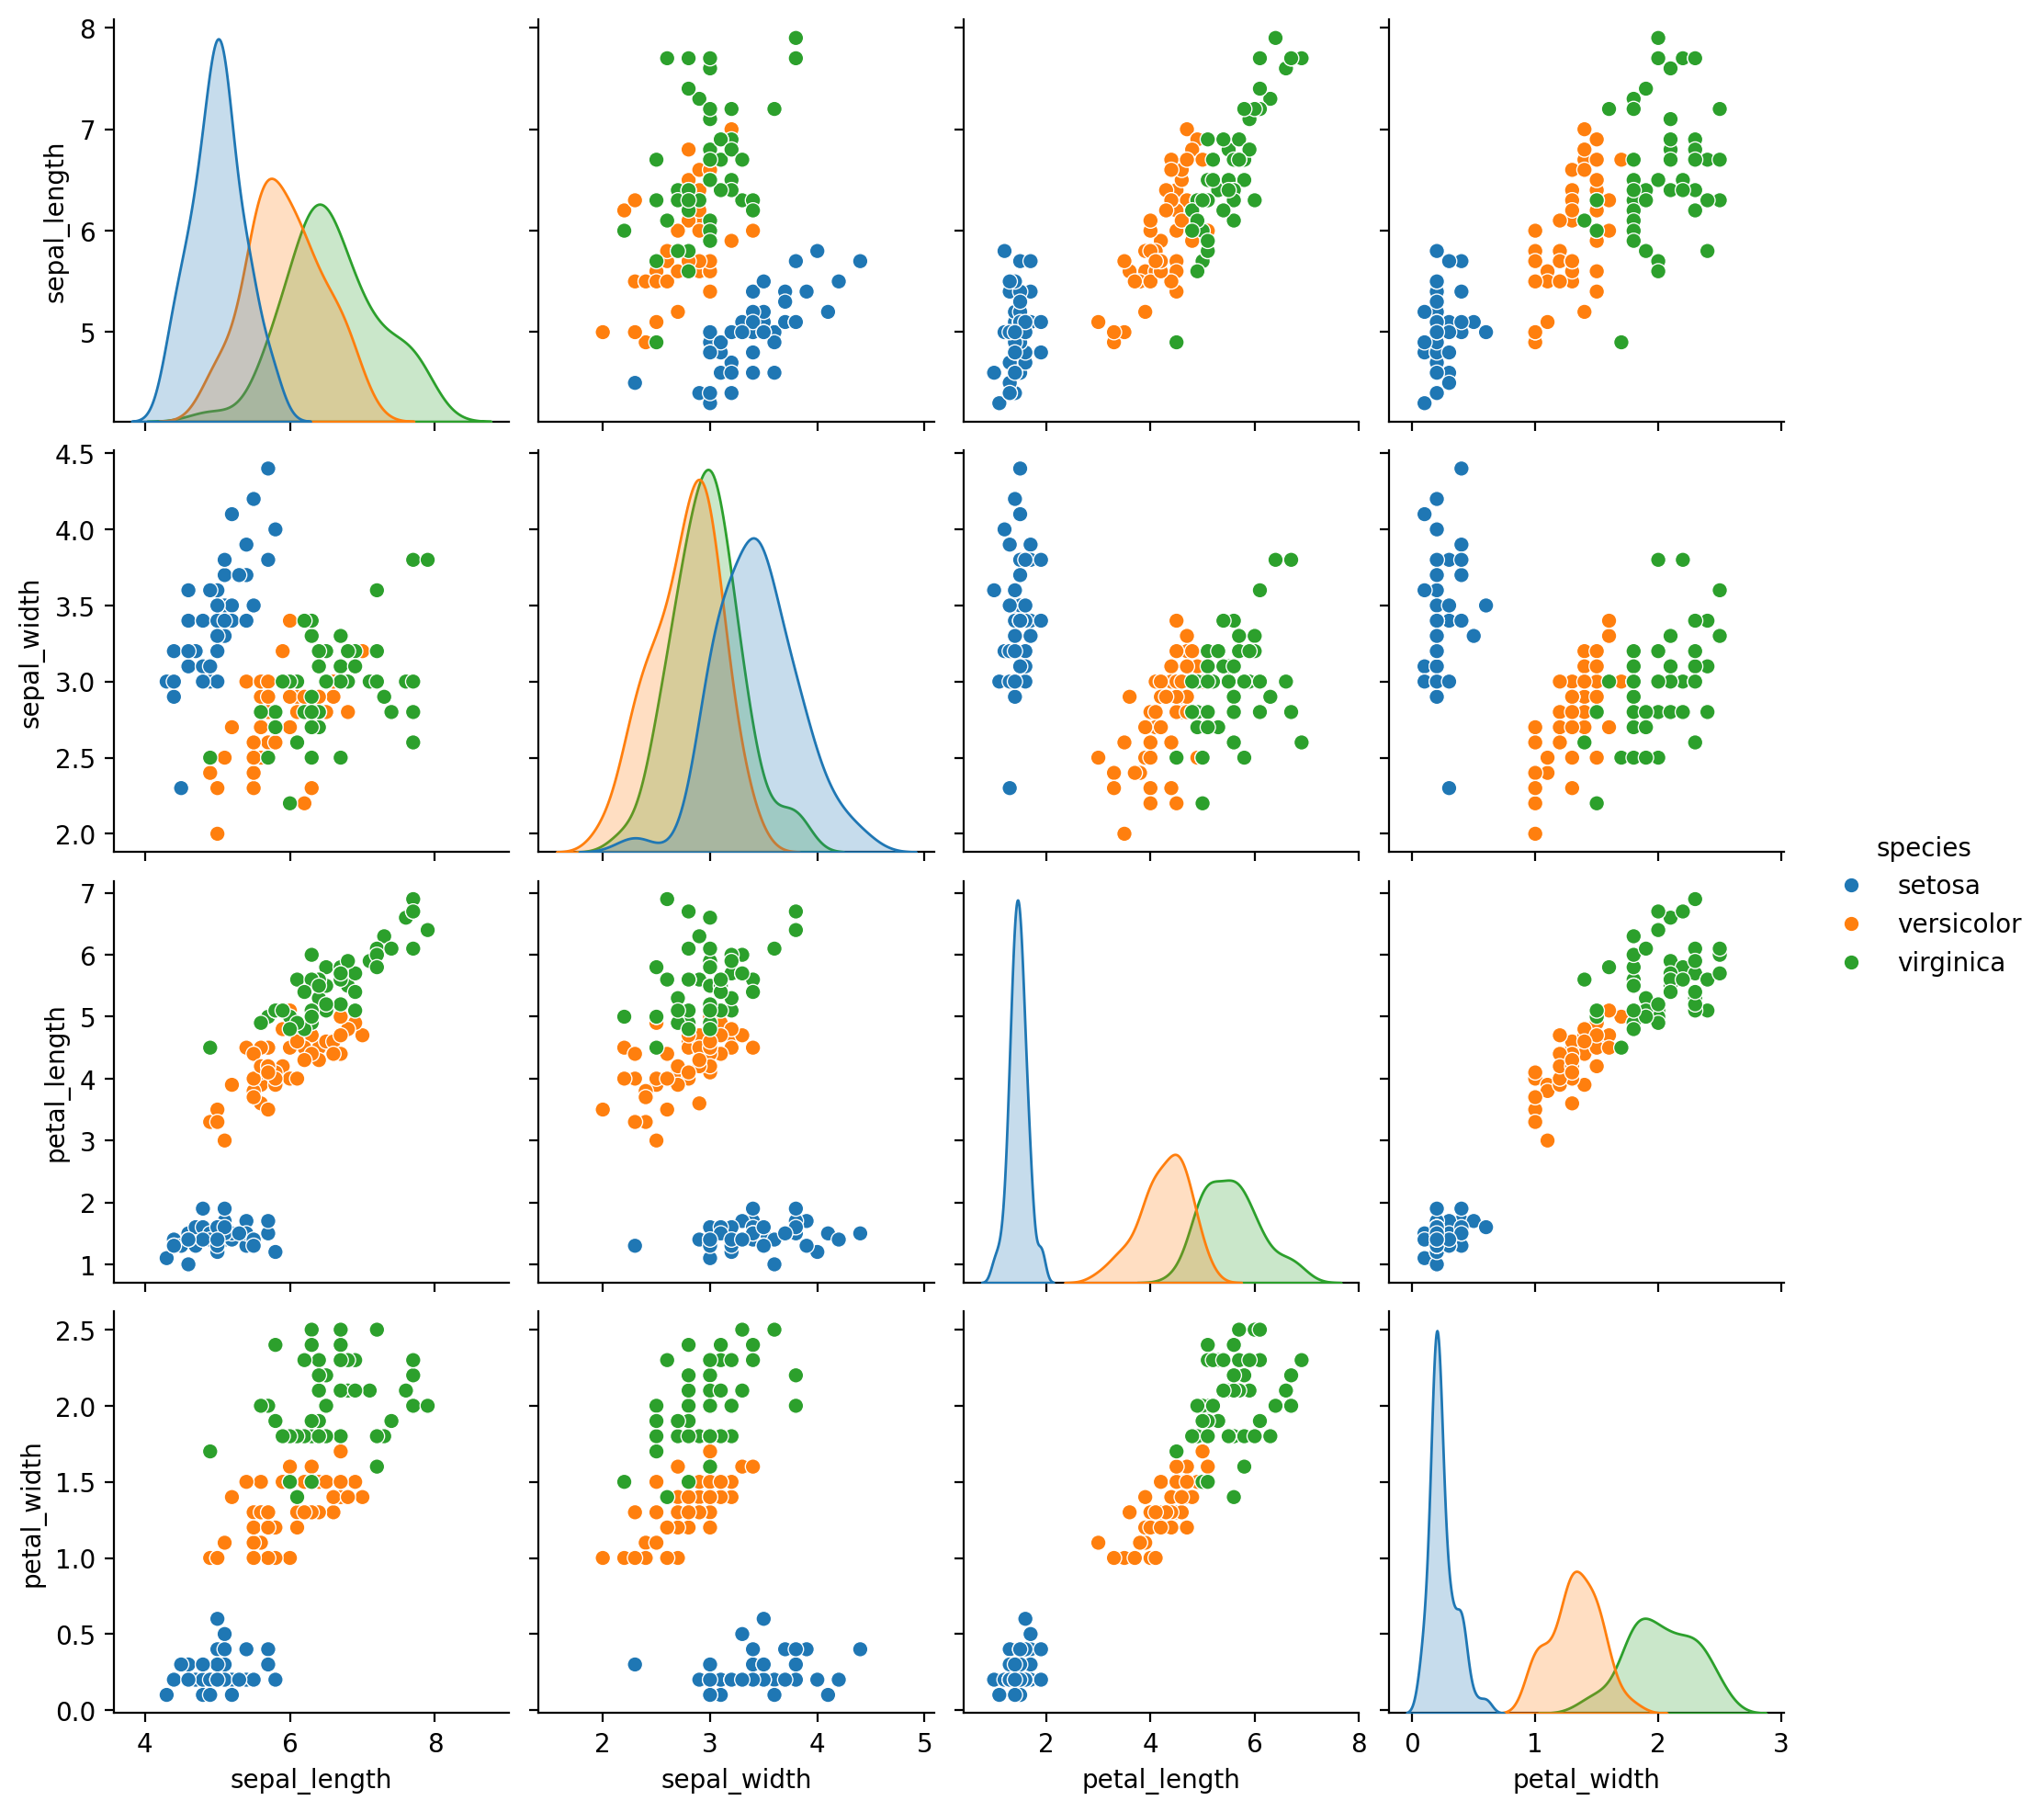

In [15]:
import seaborn as sns

# Pairplot
sns.pairplot(iris, hue="species")

In [16]:
from sklearn.ensemble import RandomForestClassifier

In [37]:
rf = RandomForestClassifier(n_estimators=10,random_state=0, criterion='entropy')

In [38]:
rf.fit(X, y)

RandomForestClassifier(criterion='entropy', n_estimators=10, random_state=0)

In [43]:
# Plot trees in forest via graphviz
from sklearn.tree import export_graphviz
import graphviz

# Visualize each tree in the Random Forest
for i, tree in enumerate(rf.estimators_):
    # Create DOT data for the i-th tree
    dot_data = export_graphviz(tree, out_file=None, 
                               feature_names=iris.columns[:-1],  
                               class_names=iris.species.unique(),
                               filled=True, rounded=True,
                               special_characters=True)
    
    # Use Graphviz to render the DOT data into a graph
    graph = graphviz.Source(dot_data)
    
    # Save or display the graph (change the format as needed)
    graph.render(filename=f'../figures/ensemble/feature-imp-{i}', format='pdf', cleanup=True)
    graph.render(filename=f'../figures/ensemble/feature-imp-{i}', format='png', cleanup=True)

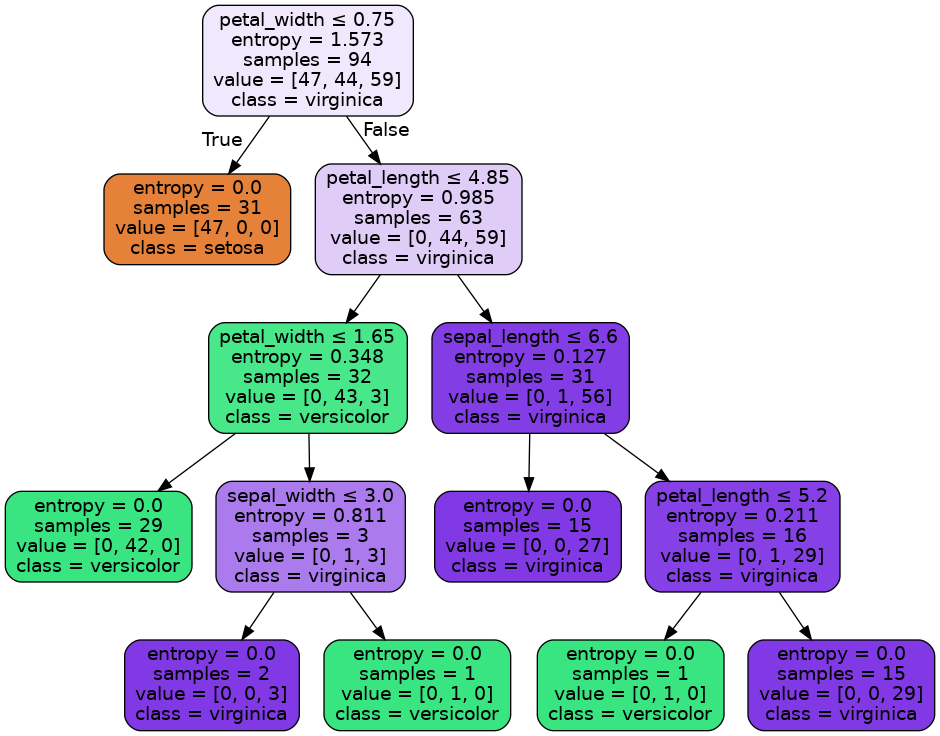

In [44]:
from IPython.display import Image
Image(filename='../figures/ensemble/feature-imp-0.png')

In [45]:
dt0 = rf.estimators_[0]

In [46]:
dt0

DecisionTreeClassifier(criterion='entropy', max_features='sqrt',
                       random_state=209652396)

In [47]:
dt0.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'entropy',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 209652396,
 'splitter': 'best'}

In [48]:
dt0.tree_.impurity

array([1.57310798, 0.        , 0.98464683, 0.34781691, 0.        ,
       0.81127812, 0.        , 0.        , 0.12741851, 0.        ,
       0.2108423 , 0.        , 0.        ])